# Padrão de Difração InP Wurtizita

Nesse programa, vamos analisar um padrão de difração referente à estrutrura cristalina **wurtizita (InP)**. O padrão de difração foi obtido através de um TEM com **200 kV**, e com o feixe de elétrons orientado na direção \$\[2\bar{1}\bar{1}0\]\$.

A imagem a ser analisada é:

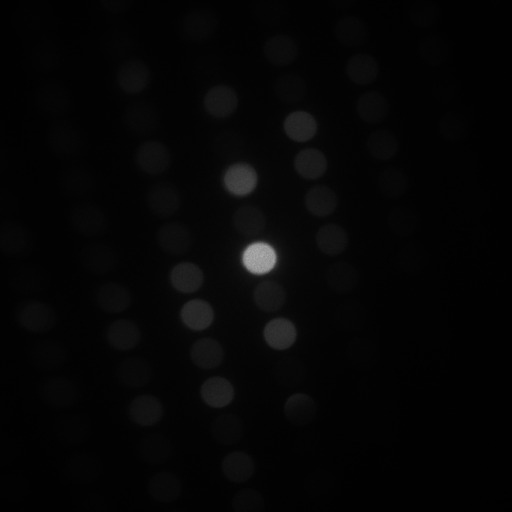

O objetivo é localizar os centros de cada ponto brilhante e fazer o ajuste de um curva circular que se baseie na intensidade dos pontos. Assim, através dos dados obtidos no ajuste, será estimado o ângulo entre o feixe incidente e o eixo de zona.

## Importação dos módulos

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.constants as const
import scipy.signal as sig
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.optimize import minimize


## Constantes 

In [14]:
# Constantes gerais
pi = const.pi            # Pi
h = const.h              # Constante de Planck
m_e = const.m_e          # Massa do elétron
e = const.e              # Carga do elétron
c = const.c              # Velocidade da luz

# Parâmetros da rede
a0=0.415e-9
c0=0.6912e-9

# Contantes do problema
V_c = 200e3              # Tensão de aceleração

# Cálculo do comprimento de onda com base na tensão de aceleração
def comprimento_onda(tensao):
    return h/(2*m_e*tensao*e*(1 + e*tensao/(2*m_e*c**2)))**0.5

Lambda = comprimento_onda(V_c)

## Funções úteis

In [15]:
# Calcula a distância entre dois pontos em um plano
def distancia(x1, x2, y1, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

# Calcula o ângulo entre dois vetores
def angulo(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/pi

# Cria uma máscara circular normalizada
def mascara_circular(raio):
    x_centro = raio
    y_centro = raio
    
    coordenadas = np.arange(2*raio + 1)
    x, y = np.meshgrid(coordenadas, coordenadas)
    
    mascara = np.where((x - x_centro)**2 + (y - y_centro)**2 <= raio**2, 1, 0)
    
    area_circulo = np.count_nonzero(mascara)
    
    mascara = np.where(mascara == 1, 1/area_circulo, 0)
    
    return mascara

# Retorna a posição do elemento de maior valor em uma lista
def posicao_max_elemento(lista):
    max_lista = max(lista)
    pos_max = 0
    while lista[pos_max] != max_lista:
        pos_max += 1
    return pos_max

# Converte a distância em pixels para distância no espaço recíproco [1/m]
def tamanho_reciproco(pixels):
    return pixels*1449275362.3188405*12/distancia(199, 318.5, 25, 481.5)

## Realização da convolução para identificar os centros e as intensidades dos pontos

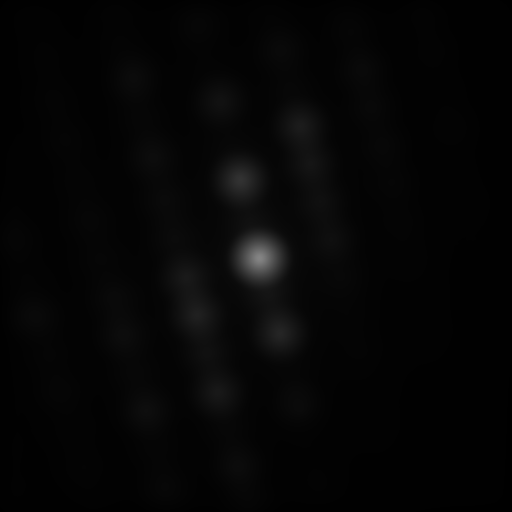

In [16]:
# Abre a imagem usando a biblioteca PIL
imagem_original = Image.open('InP7_2bin16b_03-41-Copy1.tif')

# Converte a imagem para array numpy
imagem_array = np.array(imagem_original)

# Cria uma máscara circular de raio 18
mascara = mascara_circular(18)

# Aplica a operação de convolução na imagem usando a máscara
array_res = np.around(sig.convolve2d(imagem_array, mascara, mode='same'))
array_res = array_res.astype(int)

# Cria um objeto Image a partir do array resultante
imagem_res = Image.fromarray(array_res)

imagem_res.save("convolucao.png")
imagem_res

## Localização dos centros e obtenção da intensidade dos pontos

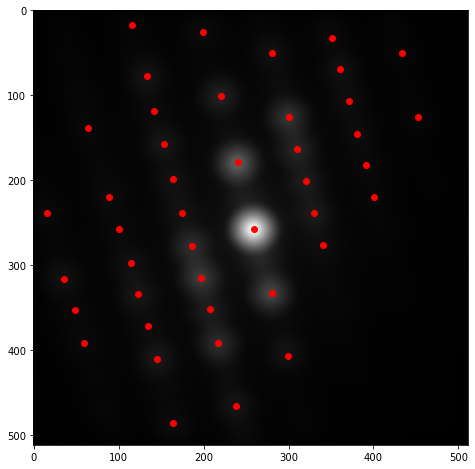

In [17]:
# Define o tamanho da vizinhança da máscara dos filtros e um threshold para eliminar ruídos
neighborhood_size = 15
threshold = 0.002

# threshold = 70
# data = array_res

data = array_res/(2**16)


# Aplica o filtro de máximo na imagem com o tamanho de vizinhança especificado
data_max = filters.maximum_filter(data, neighborhood_size)

# Cria uma máscara booleana onde as localizações dos máximos locais são verdadeiras
maxima = (data == data_max)

# Aplica o filtro de mínimo na imagem com o tamanho de vizinhança especificado
data_min = filters.minimum_filter(data, neighborhood_size)

# Atribui zero à máscara "maxima" onde a diferença é menor que o threshold (eliminação do ruído)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

# Rotula os objetos conectados na imagem "maxima", labeled é a imagem rotulada e num_objects é o número de rotulações feitas
labeled, num_objects = ndimage.label(maxima)

# Encontra os slices dos objetos
slices = ndimage.find_objects(labeled)

# Itera sobre os slices encontrados e calcula as coordenadas do centro, e com isso a intensidade do ponto
x, y, z = [], [], []
for dy,dx in slices:
    x_centro = (dx.start + dx.stop - 1)/2
    x.append(x_centro)
    y_centro = (dy.start + dy.stop - 1)/2    
    y.append(y_centro)
    z.append(data[int(x_centro)][int(y_centro)])

plt.figure(figsize = (8, 8))
plt.imshow(array_res, cmap='gray')
plt.plot(x,y, 'ro')
# for i in range(len(x)):
#     plt.annotate("(" + str(x[i]) + ", " + str(y[i]) + ")", (x[i], y[i]), color='red')

x = np.array(x)
y = np.array(y)

plt.savefig('localizacao_centros.png')

## Indexação

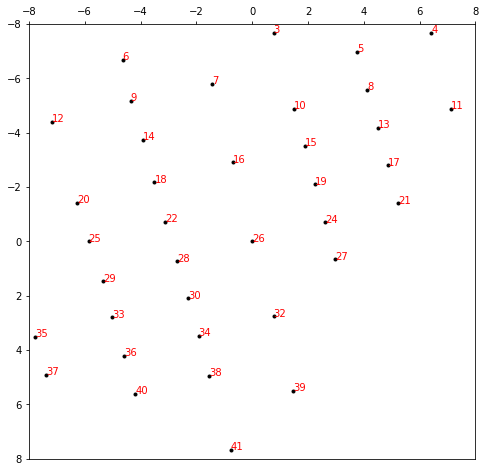

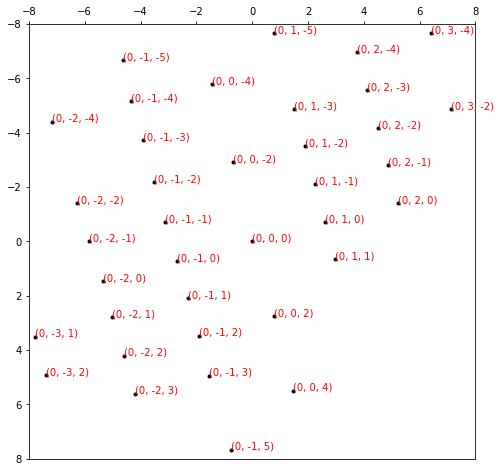

In [18]:
# Encontra a posição do ponto de máxima intensidade
pos_max = posicao_max_elemento(z)

coor_x = x - x[pos_max]
coor_y = y - y[pos_max]

coor_x = tamanho_reciproco(coor_x)*10**-9
coor_y = tamanho_reciproco(coor_y)*10**-9

plt.figure(figsize = (8, 8))
plt.axis([-8, 8, -8, 8])

ax = plt.gca()                          # Obtem o eixo
ax.set_ylim(ax.get_ylim()[::-1])        # Inverte o eixo y
ax.xaxis.tick_top()                     # Move o eixo x para cima      
ax.yaxis.tick_left()                    # Remove os ticks da direita

plt.plot(coor_x, coor_y, 'k.')
for i in range(len(coor_x)):
    plt.annotate(str(i) , (coor_x[i], coor_y[i]), color='red')
    
ab0=np.cos(np.pi/6.)*a0

# c_vetor = [coor_x[15] - coor_x[1], coor_y[15] - coor_y[1]]
# ab_vetor = [coor_x[7] - coor_x[9], coor_y[7] - coor_y[9]]

angle_c = 75.524*np.pi/180
angle_ab = -15.154*np.pi/180

# angle_c = angulo(c_vetor, [1,0])
# angle_ab = -angulo(ab_vetor, [1,0])

# print(angle_c)
# print(angle_ab)

c_versor=([np.cos(angle_c),np.sin(angle_c)])
a_versor=([np.cos(angle_ab),np.sin(angle_ab)])
a_axis=1/ab0  #reiprocal space
c_axis=1/c0   #reciprocal space

    
h_n=[]
k_n=[]
l_n=[]

for n1 in range(len(coor_x)): 
    ve_le=np.dot(c_versor,[coor_x[n1],coor_y[n1]])/10**-9
    ve_perp_le=np.dot(a_versor,[coor_x[n1],coor_y[n1]])/10**-9
    #len_ve=norm([coor_x[n1],coor_y[n1]])
    
    h_n.append(0)
    k=int(round(ve_perp_le/a_axis))
    k_n.append(k)
    l=int(round(ve_le/c_axis))
    l_n.append(l)
    h=0
    
plt.figure(figsize = (8, 8))
plt.axis([-8, 8, -8, 8])

ax = plt.gca()                          # Obtem o eixo
ax.set_ylim(ax.get_ylim()[::-1])        # Inverte o eixo y
ax.xaxis.tick_top()                     # Move o eixo x para cima      
ax.yaxis.tick_left()                    # Remove os ticks da direita

plt.plot(coor_x, coor_y, 'k.')
for i in range(len(coor_x)):
    plt.annotate("(0" + ", " + str(k_n[i]) + ", " + str(l_n[i]) + ")", (coor_x[i], coor_y[i]), color='red')

## Ajuste de uma curva circular baseando-se nas intensidades dos pontos

In [19]:
# Definição do modelo
def f(x, x_c, y_c, r): return r**2 - x**2 + 2*x_c*x - x_c**2 - y_c**2

# Função a ser minimizada
def E(x, y, z, x_c, y_c, r, x_p, y_p): 
    
    # distância entre o ponto específico e o centro do círculo
    dist = distancia(x_p, x_c, y_p, y_c)
    
    return np.sum(z*(f(x, x_c, y_c, r) - y**2 + 2*y_c*y)**2 + 10**10*(r - dist)**2)

# Define os limites das variáveis do modelo
limites_coef = [(None, None), (None, None), (0, None)]

# Encontra a posição do ponto de máxima intensidade
pos_max = posicao_max_elemento(z)

# Define as coordenadas do ponto em que a curva necessáriamente precisa cruzar
x_p = x[pos_max]
y_p = y[pos_max]

# Minimiza a função de erro
res_otimizacao = minimize(lambda coef: E(x, y, z, *coef, x_p, y_p), x0=[0, 0, 1], bounds=limites_coef)

x_c_ajustado = res_otimizacao.x[0]
y_c_ajustado = res_otimizacao.x[1]
raio_ajustado = tamanho_reciproco(res_otimizacao.x[2])

print('Coordenada x do centro:', x_c_ajustado)
print('Coordenada y do centro:', y_c_ajustado)
print('Raio:', raio_ajustado)

Coordenada x do centro: 207.79389230515233
Coordenada y do centro: 188.77032400468227
Raio: 3173576827.9450626


## Visualização do resultado

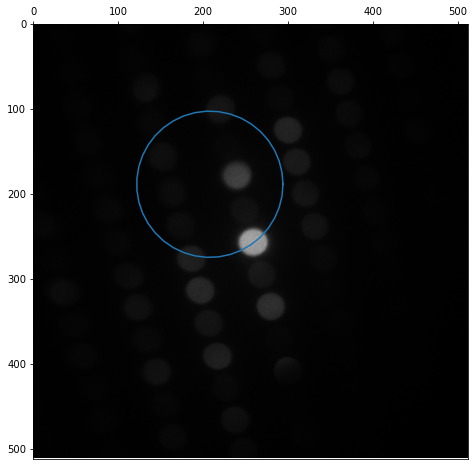

In [20]:
N = 40
valores_theta = np.linspace(0, 2*np.pi, N)

plt.figure(figsize = (8, 8))
plt.axis([0, 512, 0, 512])

ax = plt.gca()                          # Obtem o eixo
ax.set_ylim(ax.get_ylim()[::-1])        # Inverte o eixo y
ax.xaxis.tick_top()                     # Move o eixo x para cima      
ax.yaxis.tick_left()                    # Remove os ticks da direita

plt.imshow(imagem_array, cmap='gray', vmin=0, vmax=65535)
plt.plot(res_otimizacao.x[2]*np.cos(valores_theta) + res_otimizacao.x[0], res_otimizacao.x[2]*np.sin(valores_theta) + res_otimizacao.x[1])
plt.savefig('fit_circulo_png')
plt.show()

## Calculo do ângulo entre feixe incidente e o eixo de zona

In [21]:
angulo = np.arcsin(raio_ajustado*Lambda)*180/pi

print('Ângulo entre o feixe e o eixo de zona:', angulo)

Ângulo entre o feixe e o eixo de zona: 0.4560288780235218
